# Self-Attention Graph Pooling (SAGP) reproducing code
Author: 'Yeongtak Oh'

* (Original) highly-cited by 'https://github.com/inyeoplee77/SAGPool'
* torch-geometric : 'https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.SAGPooling'

In [6]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric import utils
from networks import  Net
import torch.nn.functional as F
import argparse
import os
from torch.utils.data import random_split
import easydict

# dataset selection: AIDS, DD, PROTEINS, NCI1
args = easydict.EasyDict({"seed": 777, 
                          "batch_size": 128, 
                          "lr": 0.0005, 
                          "weight_decay": 0.0001, 
                          "nhid": 128, 
                          "pooling_ratio": 0.5, 
                          "dropout_ratio": 0.5, 
                          "dataset": 'NCI1', 
                          "epochs": 100000, 
                          "patience": 50, 
                          "pooling_layer_type":'GCNConv'})

In [7]:
# device setting
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
    args.device = 'cuda:0'
    
# data load
dataset = TUDataset(os.path.join('data',args.dataset),name=args.dataset)
args.num_classes = dataset.num_classes
args.num_features = dataset.num_features
num_training = int(len(dataset)*0.8)
num_val = int(len(dataset)*0.1)
num_test = len(dataset) - (num_training+num_val)
training_set,validation_set,test_set = random_split(dataset,[num_training,num_val,num_test])

Extracting data/NCI1/NCI1/NCI1.zip
Processing...
Done!


In [11]:
# data loader & model setup
train_loader = DataLoader(training_set, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(validation_set,batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_set,batch_size=1, shuffle=False)
model = Net(args).to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

def test(model,loader):
    model.eval()
    correct = 0.
    loss = 0.
    for data in loader:
        data = data.to(args.device)
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        loss += F.nll_loss(out,data.y,reduction='sum').item()
    return correct / len(loader.dataset),loss / len(loader.dataset)

min_loss = 1e10
patience = 0
val_loss_plot = []
val_acc_plot = []
args.epochs = 150
for epoch in range(args.epochs):
    print("\n")
    print("====== epoch {} ======".format(epoch))
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(args.device)
        out = model(data)
        loss = F.nll_loss(out, data.y)
        print("Training loss:{:.3f}".format(loss.item()))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    val_acc,val_loss = test(model,val_loader)
    print("Validation loss:{:.3f}\taccuracy:{:.3f}".format(val_loss,val_acc))
    if val_loss < min_loss:
        torch.save(model.state_dict(),'latest.pth')
        print("Model saved at epoch{}".format(epoch))
        min_loss = val_loss
        patience = 0
    else:
        patience += 1
    if patience > args.patience:
        break 
    val_loss_plot.append(val_loss)
    val_acc_plot.append(val_acc)

model = Net(args).to(args.device)
model.load_state_dict(torch.load('latest.pth'))
test_acc,test_loss = test(model,test_loader)
print("Test accuarcy:{}".fotmat(test_acc))



====== epoch 0 ======
Training loss:0.698
Training loss:0.693
Training loss:0.693
Training loss:0.692
Training loss:0.694
Training loss:0.692
Training loss:0.694
Training loss:0.696
Training loss:0.692
Training loss:0.690
Training loss:0.695
Training loss:0.693
Training loss:0.693
Training loss:0.693
Training loss:0.693
Training loss:0.694
Training loss:0.693
Training loss:0.695
Training loss:0.692
Training loss:0.693
Training loss:0.693
Training loss:0.691
Training loss:0.693
Training loss:0.691
Training loss:0.693
Training loss:0.693
Validation loss:0.693	accuracy:0.479
Model saved at epoch0


====== epoch 1 ======
Training loss:0.692
Training loss:0.692
Training loss:0.695
Training loss:0.691
Training loss:0.692
Training loss:0.694
Training loss:0.689
Training loss:0.694
Training loss:0.694
Training loss:0.692
Training loss:0.693
Training loss:0.693
Training loss:0.693
Training loss:0.692
Training loss:0.693
Training loss:0.695
Training loss:0.694
Training loss:0.690
Training loss

Training loss:0.637
Training loss:0.637
Validation loss:0.625	accuracy:0.664


====== epoch 14 ======
Training loss:0.694
Training loss:0.623
Training loss:0.632
Training loss:0.595
Training loss:0.634
Training loss:0.648
Training loss:0.653
Training loss:0.681
Training loss:0.643
Training loss:0.626
Training loss:0.631
Training loss:0.645
Training loss:0.656
Training loss:0.677
Training loss:0.631
Training loss:0.620
Training loss:0.696
Training loss:0.633
Training loss:0.599
Training loss:0.621
Training loss:0.648
Training loss:0.562
Training loss:0.644
Training loss:0.630
Training loss:0.598
Training loss:0.651
Validation loss:0.624	accuracy:0.664


====== epoch 15 ======
Training loss:0.620
Training loss:0.637
Training loss:0.626
Training loss:0.670
Training loss:0.631
Training loss:0.618
Training loss:0.709
Training loss:0.630
Training loss:0.639
Training loss:0.649
Training loss:0.642
Training loss:0.623
Training loss:0.618
Training loss:0.571
Training loss:0.635
Training loss:0.

Validation loss:0.617	accuracy:0.684


====== epoch 28 ======
Training loss:0.664
Training loss:0.634
Training loss:0.626
Training loss:0.594
Training loss:0.618
Training loss:0.616
Training loss:0.609
Training loss:0.603
Training loss:0.612
Training loss:0.589
Training loss:0.570
Training loss:0.596
Training loss:0.660
Training loss:0.583
Training loss:0.576
Training loss:0.642
Training loss:0.575
Training loss:0.651
Training loss:0.581
Training loss:0.591
Training loss:0.603
Training loss:0.525
Training loss:0.661
Training loss:0.725
Training loss:0.601
Training loss:0.659
Validation loss:0.610	accuracy:0.667
Model saved at epoch28


====== epoch 29 ======
Training loss:0.611
Training loss:0.623
Training loss:0.583
Training loss:0.599
Training loss:0.619
Training loss:0.682
Training loss:0.645
Training loss:0.651
Training loss:0.591
Training loss:0.568
Training loss:0.575
Training loss:0.620
Training loss:0.604
Training loss:0.615
Training loss:0.655
Training loss:0.539
Training loss

Validation loss:0.604	accuracy:0.676


====== epoch 42 ======
Training loss:0.614
Training loss:0.543
Training loss:0.610
Training loss:0.653
Training loss:0.592
Training loss:0.584
Training loss:0.526
Training loss:0.609
Training loss:0.626
Training loss:0.565
Training loss:0.597
Training loss:0.585
Training loss:0.598
Training loss:0.515
Training loss:0.527
Training loss:0.617
Training loss:0.558
Training loss:0.640
Training loss:0.590
Training loss:0.613
Training loss:0.618
Training loss:0.596
Training loss:0.556
Training loss:0.632
Training loss:0.623
Training loss:0.609
Validation loss:0.611	accuracy:0.674


====== epoch 43 ======
Training loss:0.610
Training loss:0.592
Training loss:0.551
Training loss:0.646
Training loss:0.593
Training loss:0.574
Training loss:0.569
Training loss:0.587
Training loss:0.608
Training loss:0.587
Training loss:0.575
Training loss:0.539
Training loss:0.586
Training loss:0.571
Training loss:0.576
Training loss:0.547
Training loss:0.554
Training loss:0.

Validation loss:0.592	accuracy:0.691


====== epoch 56 ======
Training loss:0.637
Training loss:0.545
Training loss:0.567
Training loss:0.552
Training loss:0.590
Training loss:0.568
Training loss:0.598
Training loss:0.565
Training loss:0.631
Training loss:0.550
Training loss:0.505
Training loss:0.502
Training loss:0.594
Training loss:0.558
Training loss:0.652
Training loss:0.599
Training loss:0.596
Training loss:0.612
Training loss:0.567
Training loss:0.565
Training loss:0.557
Training loss:0.550
Training loss:0.614
Training loss:0.564
Training loss:0.493
Training loss:0.572
Validation loss:0.599	accuracy:0.674


====== epoch 57 ======
Training loss:0.596
Training loss:0.551
Training loss:0.619
Training loss:0.567
Training loss:0.506
Training loss:0.557
Training loss:0.555
Training loss:0.593
Training loss:0.556
Training loss:0.543
Training loss:0.555
Training loss:0.617
Training loss:0.571
Training loss:0.604
Training loss:0.639
Training loss:0.549
Training loss:0.576
Training loss:0.

Training loss:0.598
Training loss:0.524
Training loss:0.565
Training loss:0.518
Training loss:0.572
Training loss:0.615
Training loss:0.514
Training loss:0.531
Training loss:0.569
Training loss:0.577
Training loss:0.587
Training loss:0.511
Training loss:0.540
Training loss:0.580
Training loss:0.612
Training loss:0.573
Training loss:0.608
Training loss:0.555
Training loss:0.519
Training loss:0.640
Training loss:0.535
Training loss:0.583
Training loss:0.553
Training loss:0.597
Validation loss:0.587	accuracy:0.713


====== epoch 71 ======
Training loss:0.573
Training loss:0.618
Training loss:0.593
Training loss:0.541
Training loss:0.609
Training loss:0.560
Training loss:0.555
Training loss:0.588
Training loss:0.569
Training loss:0.508
Training loss:0.570
Training loss:0.573
Training loss:0.625
Training loss:0.607
Training loss:0.554
Training loss:0.516
Training loss:0.607
Training loss:0.509
Training loss:0.545
Training loss:0.538
Training loss:0.525
Training loss:0.592
Training loss:0.60

Training loss:0.612
Training loss:0.576
Training loss:0.540
Training loss:0.532
Training loss:0.544
Training loss:0.521
Training loss:0.524
Training loss:0.566
Training loss:0.561
Training loss:0.521
Training loss:0.552
Training loss:0.505
Training loss:0.550
Training loss:0.522
Training loss:0.565
Training loss:0.572
Training loss:0.557
Training loss:0.574
Training loss:0.575
Training loss:0.601
Validation loss:0.594	accuracy:0.703


====== epoch 85 ======
Training loss:0.583
Training loss:0.474
Training loss:0.552
Training loss:0.536
Training loss:0.600
Training loss:0.566
Training loss:0.612
Training loss:0.506
Training loss:0.568
Training loss:0.557
Training loss:0.532
Training loss:0.569
Training loss:0.502
Training loss:0.591
Training loss:0.539
Training loss:0.572
Training loss:0.455
Training loss:0.565
Training loss:0.630
Training loss:0.550
Training loss:0.552
Training loss:0.657
Training loss:0.605
Training loss:0.539
Training loss:0.520
Training loss:0.572
Validation loss:0.

Training loss:0.593
Training loss:0.525
Training loss:0.442
Training loss:0.588
Training loss:0.567
Training loss:0.625
Training loss:0.578
Training loss:0.555
Training loss:0.621
Training loss:0.481
Training loss:0.504
Training loss:0.563
Training loss:0.563
Validation loss:0.600	accuracy:0.698


====== epoch 99 ======
Training loss:0.603
Training loss:0.539
Training loss:0.522
Training loss:0.523
Training loss:0.544
Training loss:0.578
Training loss:0.559
Training loss:0.576
Training loss:0.523
Training loss:0.544
Training loss:0.578
Training loss:0.600
Training loss:0.461
Training loss:0.513
Training loss:0.630
Training loss:0.575
Training loss:0.523
Training loss:0.519
Training loss:0.562
Training loss:0.489
Training loss:0.547
Training loss:0.557
Training loss:0.563
Training loss:0.485
Training loss:0.612
Training loss:0.553
Validation loss:0.597	accuracy:0.708


====== epoch 100 ======
Training loss:0.546
Training loss:0.534
Training loss:0.452
Training loss:0.538
Training loss:0

Training loss:0.537
Training loss:0.529
Training loss:0.548
Training loss:0.530
Training loss:0.540
Training loss:0.499
Training loss:0.518
Validation loss:0.600	accuracy:0.708


====== epoch 113 ======
Training loss:0.549
Training loss:0.462
Training loss:0.519
Training loss:0.585
Training loss:0.553
Training loss:0.534
Training loss:0.486
Training loss:0.574
Training loss:0.528
Training loss:0.560
Training loss:0.420
Training loss:0.558
Training loss:0.538
Training loss:0.662
Training loss:0.545
Training loss:0.505
Training loss:0.585
Training loss:0.511
Training loss:0.500
Training loss:0.521
Training loss:0.449
Training loss:0.568
Training loss:0.587
Training loss:0.526
Training loss:0.561
Training loss:0.557
Validation loss:0.597	accuracy:0.713


====== epoch 114 ======
Training loss:0.486
Training loss:0.576
Training loss:0.521
Training loss:0.521
Training loss:0.590
Training loss:0.544
Training loss:0.575
Training loss:0.520
Training loss:0.493
Training loss:0.564
Training loss:

AttributeError: 'str' object has no attribute 'fotmat'

/home/ywkim/pytorch_geometric/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


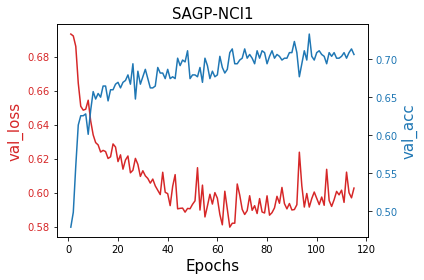

In [13]:
import matplotlib.pyplot as plt
import numpy as np

num_xaxis = 115 #args.epochs
fig, ax1 = plt.subplots()
x_axis = np.linspace(1,num_xaxis,num=num_xaxis)
color = 'tab:red'
ax1.set_xlabel('Epochs',fontsize=15)
ax1.set_ylabel('val_loss', color=color,fontsize=15)
ax1.plot(x_axis, val_loss_plot, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('val_acc', color=color,fontsize=15) 
ax2.plot(x_axis, val_acc_plot, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title('SAGP-'+str(args.dataset),fontsize=15)

fig.tight_layout()
fig.show()
fig.savefig('./GNN_'+str(args.dataset)+'_'+str(epoch)+'.pdf',dpi=350)